# Day 1 · Notebook 02 — CNN Intro & Training Warm-Up
We move from pixel manipulations to an end-to-end convolutional classifier. This notebook mirrors Block 4 of the course plan: start with an intuition for kernels/pooling, then train a compact CNN using the shared `cvcourse` helpers so every later notebook can reuse the same pieces.

In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd().resolve()
while not (ROOT / "pyproject.toml").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if not (ROOT / "pyproject.toml").exists():
    raise FileNotFoundError("Could not locate repository root containing pyproject.toml")
SRC_DIR = ROOT / "src"
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from typing import List
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim

from cvcourse.config import load_config
from cvcourse.data.loaders import get_dataloaders
from cvcourse.models.cnn_classification import SimpleCNN
from cvcourse.training.loops import evaluate, train_one_epoch
from cvcourse.utils.device import get_device,to_device
from cvcourse.viz.images import show_batch
from cvcourse.viz.feature_maps import visualize_feature_maps

plt.style.use("ggplot")
torch.manual_seed(0)

The first cell makes the notebook self-contained: we walk up the directory tree until we find `pyproject.toml`, add both the repo root and `src/` folder to `sys.path`, and only then import the `cvcourse` helpers. This avoids the classic “module not found” error when students launch the notebook from `notebooks/day1`. We also set a global matplotlib style and seed PyTorch so that every learner sees identical toy images, kernels, and training curves—perfect for debugging mismatched results.

## 1. Load the shared experiment config
All Day 1 notebooks reuse the same YAML-driven configuration so we can tweak datasets or limits without editing code. We'll parse `configs/day1_cnn.yaml`, which keeps the training fast by limiting the number of samples.

In [2]:
config_path = ROOT / "configs" / "day1_cnn.yaml"
config = load_config(config_path)
config_dict = config.__dict__.copy()
config_dict['extras'] = config.extras
pd.DataFrame({"config": list(config_dict.keys()), "value": list(config_dict.values())})

,config,value
0,name,day1_cnn
1,dataset,mnist
2,model,simple_cnn
3,batch_size,64
4,num_workers,2
5,learning_rate,0.001
6,epochs,5
7,allow_gpu,False
8,extras,"{'augment': False, 'limit_train_samples': 2048..."


Skim this table before you run anything else. The `limit_train`/`limit_val` entries throttle how many samples each epoch sees (smaller numbers = faster iterations). `allow_gpu` controls whether `torch.device` points to CUDA, `extras` houses knobs like data augmentation, and the optimizer hyperparameters (learning rate, batch size) live alongside the dataset name so every Day 1 notebook stays in sync. Make changes in `configs/day1_cnn.yaml`, rerun this cell, and the updates propagate everywhere.

## 2. Warm-up: kernels & pooling on a toy image
Convolutions are nothing more than weighted sums sliding across pixels. Use the next two cells as an interactive sandbox:
- **Cell 1 – Write your filters.** Start from the provided edge kernel, then fill in the TODO entries for blur and sharpen (or swap in any other 3×3 kernel you want to test). Keep values small so the outputs stay visible without rescaling.
- **Cell 2 – See what they do.** Run the execution cell to apply every kernel to both the handcrafted 7×7 patch and the real cat photo. The cell validates shapes, shows the toy convolutions side by side, reports max/avg pooling shapes, and finally displays the filtered sample image.
- **Iterate quickly.** Tweak the weights in Cell 1, rerun Cell 2, and compare how the same kernel behaves on synthetic vs. natural content. This mirrors how learned CNN filters respond to different textures.

In [3]:
# TODO: Hand-code each 3×3 kernel so students can inspect their effects on the toy patch + sample image.
edge_kernel = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32)
sobel_kernel = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)

# Fill these with your own 3×3 tensors (dtype float32). Keep values small so outputs stay in [-1, 1].
blur_kernel = None  # e.g., torch.ones((3, 3), dtype=torch.float32) / 9.0
sharpen_kernel = None  # e.g., torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32)

kernels = {
    "edge": edge_kernel,
    "sobel": sobel_kernel,
    # "blur": blur_kernel,
    # "sharpen": sharpen_kernel,
}

Max pool shape: torch.Size([1, 1, 3, 3]) Avg pool shape: torch.Size([1, 1, 3, 3])


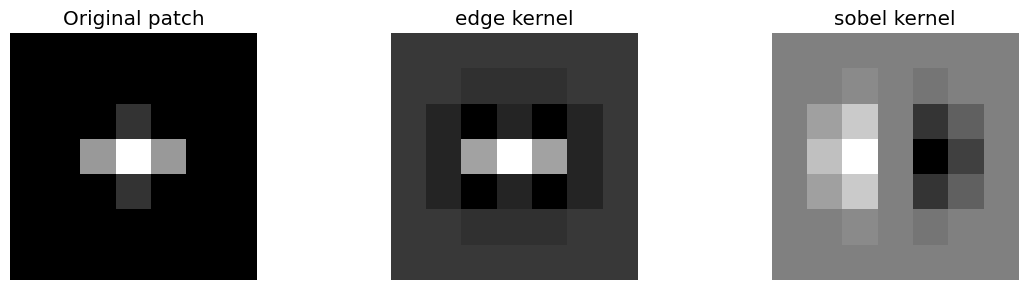

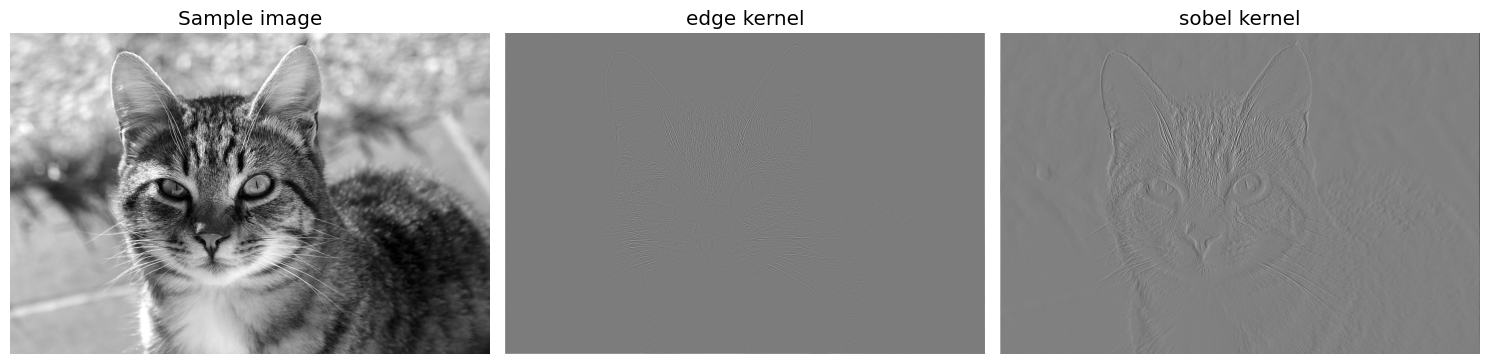

In [4]:
import torch.nn.functional as F
from PIL import Image
import numpy as np
from typing import Optional

def _prepare_kernel(name: str, kernel: Optional[torch.Tensor]) -> torch.Tensor:
    if kernel is None:
        raise ValueError(f"Kernel '{name}' is not defined—fill it in the previous cell.")
    if kernel.shape != (3, 3):
        raise ValueError(f"Kernel '{name}' must be 3×3, got shape {tuple(kernel.shape)}")
    return kernel.view(1, 1, 3, 3)

# --- Synthetic 7×7 patch ---
toy = torch.zeros((1, 1, 7, 7))
toy[:, :, 2:5, 2:5] = torch.tensor([[0.0, 0.2, 0.0], [0.6, 1.0, 0.6], [0.0, 0.2, 0.0]])
fig, axes = plt.subplots(1, len(kernels) + 1, figsize=(12, 3))
axes[0].imshow(toy.squeeze(), cmap="gray")
axes[0].set_title("Original patch")
axes[0].axis("off")
for idx, (name, kernel) in enumerate(kernels.items(), start=1):
    weight = _prepare_kernel(name, kernel)
    convolved = F.conv2d(toy, weight, padding=1)
    axes[idx].imshow(convolved.detach().squeeze(), cmap="gray")
    axes[idx].set_title(f"{name} kernel")
    axes[idx].axis("off")
plt.tight_layout()

pooled_max = F.max_pool2d(toy, kernel_size=2, stride=2)
pooled_avg = F.avg_pool2d(toy, kernel_size=2, stride=2)
print("Max pool shape:", pooled_max.shape, "Avg pool shape:", pooled_avg.shape)

# --- Real sample image ---
data_path = ROOT / "data"
sample_image = data_path / "sample_image.jpeg"
if not sample_image.exists():
    raise FileNotFoundError(f"Sample image not found at {sample_image}")
image_gray = Image.open(sample_image).convert("L")
image_tensor = torch.from_numpy(np.array(image_gray, dtype=np.float32) / 255.0).unsqueeze(0).unsqueeze(0)

fig, axes = plt.subplots(1, len(kernels) + 1, figsize=(15, 4))
axes[0].imshow(image_gray, cmap="gray")
axes[0].set_title("Sample image")
axes[0].axis("off")

for idx, (name, kernel) in enumerate(kernels.items(), start=1):
    weight = _prepare_kernel(name, kernel)
    filtered = F.conv2d(image_tensor, weight, padding=1)
    axes[idx].imshow(filtered.squeeze().numpy(), cmap="gray")
    axes[idx].set_title(f"{name} kernel")
    axes[idx].axis("off")

plt.tight_layout()

In [6]:
toy, edge_kernel

(tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.6000, 1.0000, 0.6000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]]),
 tensor([[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]]))

## 3. Build dataloaders the course way
`cvcourse.data.loaders.get_dataloaders` wraps TorchVision datasets with the exact transforms we expect later (tensor conversion, normalization, optional augmentation). It also honors the YAML sample limits so a full epoch touches only a few hundred images—perfect for CPU demos. Running the next cell should reassure you that downloads succeeded, tensors have shape `[batch, channels, height, width]`, and labels still map to the correct class IDs.

Think of the pipeline like this:
1. **Dataset returns a single image** as a PIL object or tensor shaped `[C, H, W]` (for MNIST, `C=1`, `H=W=28`).
2. **Transforms normalize and convert** the image so pixels live in `[0, 1]` floats and channels sit in the first dimension—exactly what PyTorch convolutions expect.
3. **DataLoader stacks samples** from step 2 into a batch tensor of shape `[B, C, H, W]` using `torch.stack`; this adds the batch dimension `B`, which lets us exploit vectorized ops and run backprop on many images at once.
4. **Collate labels** into a vector of length `B`, so every image in the batch carries its target index.
5. **Optional extras (augmentations, shuffling, limits)** are injected here, which is why we centralize loader creation inside `cvcourse.data.loaders`.

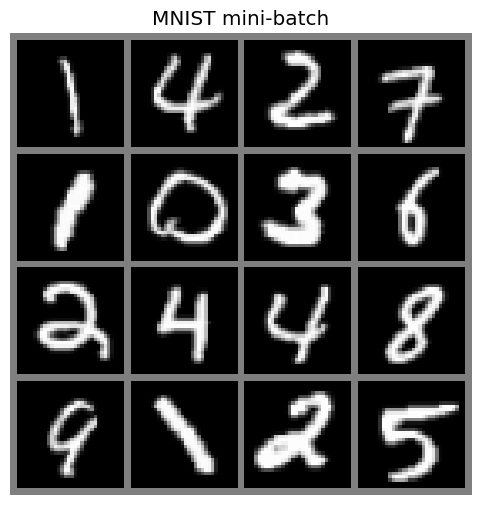

Train batch shape: (64, 1, 32, 32) | dtype=torch.float32
Val batches: 8 | Train batches: 32
Sample labels: [1, 4, 2, 7, 1, 0, 3, 6, 2, 4]


In [7]:
train_loader, val_loader = get_dataloaders(config)
images, targets = next(iter(train_loader))
show_batch(images, title=f"{config.dataset.upper()} mini-batch")
print(f"Train batch shape: {tuple(images.shape)} | dtype={images.dtype}")
print(f"Val batches: {len(val_loader)} | Train batches: {len(train_loader)}")
print(f"Sample labels: {targets[:10].tolist()}")

When the batch grid renders correctly you have verified three things at once: (1) the dataset exists on disk, (2) the transforms returned contiguous tensors shaped `[B, C, H, W]` with `B=batch size`, and (3) labels fall inside the expected range (0–9 for MNIST by default). If you ever change datasets, rerun this check to ensure image sizes or color channels match the model configuration, and remember that the only new dimension compared to a single image is the batch axis prepended by the loader.

## 4. Instantiate the SimpleCNN
We follow a repeatable recipe:
1. **Unwrap the dataset** in case it is wrapped by samplers or subsets.
2. **Infer channel count** straight from the first batch tensor (`images.shape[1]`).
3. **Infer number of classes** by reading dataset metadata (`classes`) or, as a fallback, scanning observed labels.
4. **Create the model** with those two numbers so layer shapes align without hard-coding.
5. **Select a device** (`cpu` by default, `cuda` when `allow_gpu=True`).
6. **Report parameter totals** to build intuition about model capacity before training kicks off.

In [8]:
def unwrap_dataset(ds):
    while hasattr(ds, "dataset"):
        ds = ds.dataset
    return ds

def infer_num_classes(loader) -> int:
    base = unwrap_dataset(loader.dataset)
    if hasattr(base, "classes"):
        return len(base.classes)
    targets = getattr(base, "targets", None)
    if targets is not None:
        if isinstance(targets, torch.Tensor):
            return len(torch.unique(targets))
        return len(set(targets))
    observed: List[int] = []
    for _, labels in itertools.islice(iter(loader), 5):
        observed.extend(labels.tolist())
    return len(set(observed))

in_channels = images.shape[1]
num_classes = infer_num_classes(train_loader)
model = SimpleCNN(num_classes=num_classes, in_channels=in_channels)
device = get_device(config.allow_gpu)
model_summary = sum(p.numel() for p in model.parameters())
print(f"Model has {model_summary/1e3:.1f}K params | device={device}")
model

Model has 110.5K params | device=cpu


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 5. Count CNN parameters by hand
Every convolutional layer stores `(out_channels × in_channels × kernel_h × kernel_w) + out_channels` parameters (weights plus one bias per filter). Fully connected layers follow the classic `(in_features × out_features) + out_features` rule. Verifying these numbers guards against accidental architectural bloat and helps you reason about memory footprint. The snippet below walks through the calculation for `SimpleCNN` using both formulas and PyTorch’s built-in parameter tensors.

Before jumping into the full network, use the tiny template right below to practice:
1. Inspect the auto-generated table and write down the formula for each layer.
2. Change the model definition and re-run to see the different counts
3. Does your intuition match with the printed results?


In [9]:
import torch.nn as nn
from typing import Dict

class TinyConvNet(nn.Module):
    """Three learnable layers small enough for manual parameter counting."""
    def __init__(self) -> None:
        super().__init__()
        # First block: 1 grayscale channel → 2 feature maps via 3×3 kernels.
        # Padding keeps the spatial size at 8×8 so counting is easier.
        self.features = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, padding=1),
            nn.ReLU(),
            # Second conv grows the channel count again while shrinking spatial dims.
            nn.Conv2d(2, 4, kernel_size=3, padding=0),
            nn.ReLU(),
        )
        # Adaptive pooling enforces a fixed 4×4 map regardless of upstream edits.
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # keeps math tidy
        # Fully connected head sees (channels × height × width) features per sample.
        self.classifier = nn.Linear(4 * 4 * 4, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Convolutional feature extractor.
        x = self.features(x)
        # Collapse spatial size to 4×4 while preserving channel count.
        x = self.pool(x)
        # Flatten and run through the linear classifier.
        return self.classifier(x.view(x.size(0), -1))

tiny_net = TinyConvNet()
tiny_total = sum(p.numel() for p in tiny_net.parameters())
print(f"TinyConvNet has {tiny_total} parameters")

layer_templates = []
_answer_key: Dict[str, int] = {}

for name, module in tiny_net.named_modules():
    if isinstance(module, nn.Conv2d):
        k_h, k_w = module.kernel_size
        bias_terms = module.out_channels if module.bias is not None else 0
        formula_hint = f"({module.out_channels} * {module.in_channels} * {k_h} * {k_w}) + {bias_terms}"
        manual = module.weight.numel() + (module.bias.numel() if module.bias is not None else 0)
        _answer_key[name] = manual
        layer_templates.append({
            "layer": name,
            "type": "Conv2d",
            "hint": formula_hint,
            "ground_truth": manual,
        })
    elif isinstance(module, nn.Linear):
        bias_terms = module.out_features if module.bias is not None else 0
        formula_hint = f"({module.in_features} * {module.out_features}) + {bias_terms}"
        manual = module.weight.numel() + (module.bias.numel() if module.bias is not None else 0)
        _answer_key[name] = manual
        layer_templates.append({
            "layer": name,
            "type": "Linear",
            "hint": formula_hint,
            "ground_truth": manual,
        })

breakdown_df = pd.DataFrame(layer_templates)
display(breakdown_df)

TinyConvNet has 291 parameters


,layer,type,hint,ground_truth
0,features.0,Conv2d,(2 * 1 * 3 * 3) + 2,20
1,features.2,Conv2d,(4 * 2 * 3 * 3) + 4,76
2,classifier,Linear,(64 * 3) + 3,195


## 6. Train + evaluate (fast CPU loop)
Inside each epoch we repeat four steps:
1. **Forward + backward pass** on every training batch via `train_one_epoch`, which returns the mean loss.
2. **Optimizer step** (Adam here) updates weights using the accumulated gradients.
3. **Validation sweep** with `evaluate`, which disables gradient tracking and returns `(accuracy, loss)` on the held-out loader.
4. **Logging** – append the metrics to `history` and print a concise summary so you can monitor progress live. Because `limit_train` is tiny, expect some variance; we just want to confirm the loop executes end-to-end.

In [10]:
history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

for epoch in range(1, config.epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, device)
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch}/{config.epochs} → train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc*100:.1f}%")

Epoch 1/5 → train_loss=2.2994 | val_loss=2.2762 | val_acc=24.2%
Epoch 2/5 → train_loss=2.1533 | val_loss=1.9289 | val_acc=27.3%
Epoch 3/5 → train_loss=1.8513 | val_loss=1.6690 | val_acc=37.5%
Epoch 4/5 → train_loss=1.7000 | val_loss=1.5837 | val_acc=41.4%
Epoch 5/5 → train_loss=1.6397 | val_loss=1.5591 | val_acc=43.0%


Expect validation accuracy to land around 50–60 % with the tiny training slice; that’s fine for a warm-up. If you see NaNs or rapidly increasing loss, double-check the learning rate in the YAML or reduce the batch size. On GPUs, clear memory with `torch.cuda.empty_cache()` before rerunning long loops.

## 7. Plot learning curves
Turn the raw `history` dict into a DataFrame so we can:
1. Plot **train vs. val loss** on the same axes—healthy runs show both curves descending, with validation slightly higher than training.
2. Plot **validation accuracy** separately with y-limits `[0, 1]` so percentages map directly to probability.
3. Inspect the final row of the DataFrame to capture the last metrics numerically (handy for logging or comparisons).
4. Use these plots to diagnose issues quickly: e.g., if both losses plateau, increase epochs; if they diverge, add regularization or more data.

,epoch,train_loss,val_loss,val_acc
4,5,1.639738,1.559141,0.429688


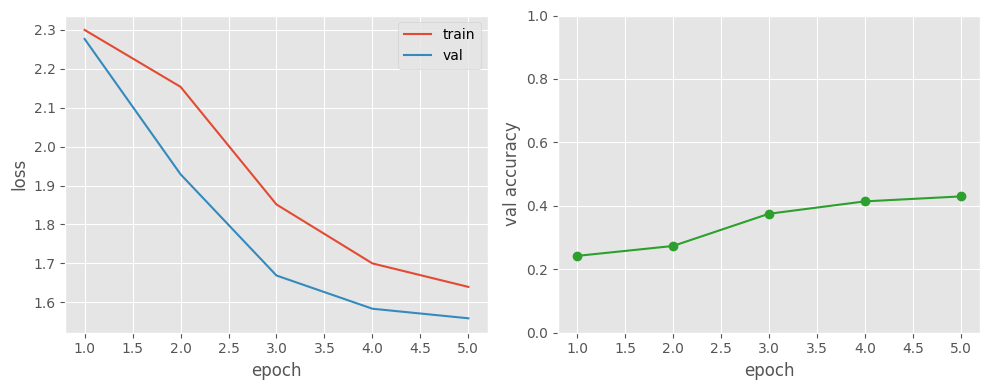

In [11]:
history_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history_df['epoch'], history_df['train_loss'], label='train')
axes[0].plot(history_df['epoch'], history_df['val_loss'], label='val')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()
axes[1].plot(history_df['epoch'], history_df['val_acc'], marker='o', color='tab:green')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('val accuracy')
axes[1].set_ylim(0, 1)
plt.tight_layout()
history_df.tail(1)

Use this as your debugging dashboard: diverging train/val loss means overfitting, flat lines usually signal a learning-rate typo or frozen layers. Screenshot the figure during class so students can compare against their own runs.

## 8. Qualitative spot-check
Workflow for this cell:
1. Switch the model to `eval()` and grab a validation batch so gradients stay off.
2. Run a forward pass, take `argmax` along the class dimension to get predicted labels, and move tensors back to CPU for plotting.
3. Convert each `[C, H, W]` tensor to `[H, W, C]`, handling grayscale vs. RGB cases separately.
4. Annotate each subplot with `pred | true` so misclassifications pop out visually. Ten samples are enough to catch glaring issues like flipped channels or label offsets.

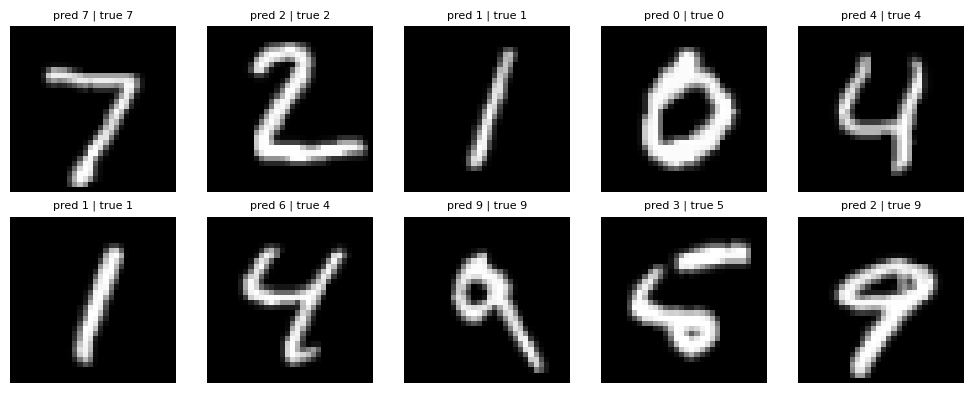

In [12]:
model.eval()
sample_images, sample_labels = next(iter(val_loader))
with torch.no_grad():
    logits = model(to_device(sample_images, device))
preds = logits.argmax(dim=1).cpu()
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for ax, img, pred, label in zip(axes, sample_images[:10], preds[:10], sample_labels[:10]):
    img_np = img.permute(1, 2, 0).numpy()
    if img_np.shape[2] == 1:
        img_np = img_np[:, :, 0]
        ax.imshow(img_np, cmap='gray')
    else:
        ax.imshow(np.clip(img_np, 0, 1))
    ax.axis('off')
    ax.set_title(f"pred {pred.item()} | true {label.item()}", fontsize=8)
plt.tight_layout()

Look for systematic mistakes (e.g., confusing 3 vs. 5). If every title reads `pred == true`, you may have accidentally visualized the training batch; swap to `val_loader` to keep the check honest.

## 9. Peek at early feature maps
Feature-map inspection also has a repeatable recipe:
1. **Register a forward hook** on the first convolution layer so PyTorch hands us its output tensor during the next pass.
2. **Run a small batch through the network** (no gradients needed) and immediately remove the hook so future passes stay lightweight.
3. **Detach + move to CPU** only the first sample’s activations to keep memory manageable.
4. **Visualize several channels** side by side; bright areas indicate where the learned filter fired strongly. Compare these textures to the handcrafted kernels from Section 2 to connect intuition with learned representations.

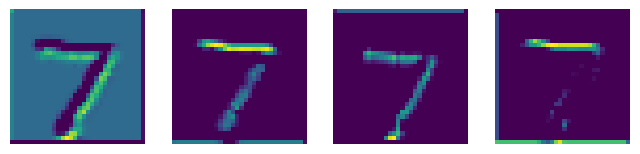

In [13]:
activations: List[torch.Tensor] = []

def first_layer_hook(_module, _inp, output):
    activations.append(output.detach().cpu()[0])  # store first sample (C,H,W)

handle = model.features[0].register_forward_hook(first_layer_hook)
with torch.no_grad():
    _ = model(to_device(sample_images[:4], device))
handle.remove()
if activations:
    visualize_feature_maps(activations, num_maps=4)
else:
    print("Hook produced no activations; rerun the previous cells.")

If hooks slow things down, capture just one forward pass as shown here. During class, pause on the visualizer output and ask which filters resemble the handcrafted kernels from Section 2—this ties the intuition back to real features.

## 10. Where to go next
- Increase `limit_train`/`limit_val` or switch datasets in the YAML to see how capacity and training time change.
- Toggle `extras["augment"]` to quantify the gain from simple augmentations before Notebook 04 dives deeper.